In [1]:
# ========================================
# 1. IMPORTS & SETUP
# ========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
import random
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats 
import scipy

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NUM_CLASSES = 10

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LOCAL_EPOCHS = 5
NUM_OF_CLIENTS = 10
COMM_ROUND = 50
ALPHA = 0.5
FRAC = 0.1
RHO = 0.05  # SAM perturbation radius (from paper)

Using device: cuda


In [8]:
# ========================================
# 2. MODEL: SimpleCNN (returns features + logits)
# ========================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        f1 = F.relu(self.bn_fc1(self.fc1(x)))
        f1 = self.dropout1(f1)
        f2 = F.relu(self.bn_fc2(self.fc2(f1)))
        f2 = self.dropout2(f2)
        logits = self.fc3(f2)
        return f2, logits  # features, logits


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    print("ALPHA = ", alpha)

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

# ========================================
# 3. TEMPNET
# ========================================
class TempNet(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128, tau_min=0.05, tau_max=2.0):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tau_min = tau_min
        self.tau_max = tau_max

    def forward(self, x):
        h = F.relu(self.fc1(x))
        raw = self.fc2(h)
        tau = torch.sigmoid(raw)
        tau = tau * (self.tau_max - self.tau_min) + self.tau_min
        return tau.mean()

# ========================================
# 5. FedSAM CLIENT (Original - FIXED)
# ========================================
class ClientFedSAM:
    def __init__(self, cid, model, train_loader, val_loader, device, lr=LEARNING_RATE, local_ep=LOCAL_EPOCHS, rho=RHO):
        self.cid = cid
        self.model = copy.deepcopy(model).to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = lr
        self.local_ep = local_ep
        self.rho = rho

    def compute_sam_update(self, X, y):
        self.model.train()
        opt = optim.SGD(self.model.parameters(), lr=self.lr)

        # Step 1: Compute gradient at current weights
        opt.zero_grad()
        _, logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad_norm = torch.nn.utils.parameters_to_vector(
            [p.grad for p in self.model.parameters() if p.grad is not None]
        ).norm()

        if grad_norm == 0:
            return

        # SAVE ORIGINAL WEIGHTS
        original_params = [p.clone() for p in self.model.parameters()]

        # Step 2: Compute perturbation ε = ρ * ∇L / ||∇L||
        eps = self.rho * torch.nn.utils.parameters_to_vector(
            [p.grad / grad_norm for p in self.model.parameters() if p.grad is not None]
        )

        # Step 3: Ascent step: w ← w + ε
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.grad.numel()
                p.data.add_(eps[idx:idx+numel].view_as(p))
                idx += numel

        # Step 4: Compute gradient at perturbed point
        opt.zero_grad()
        _, logits_pert = self.model(X)
        loss_pert = F.cross_entropy(logits_pert, y)
        loss_pert.backward()

        # RESTORE ORIGINAL WEIGHTS BEFORE DESCENT
        for p, p_orig in zip(self.model.parameters(), original_params):
            p.data.copy_(p_orig)

        # Step 5: Descent step using gradient at perturbed point
        opt.step()

    def update(self, global_state, rnd):
        self.model.load_state_dict(global_state)
        for _ in range(self.local_ep):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.compute_sam_update(X, y)
        return self.model.state_dict()

    def local_val_acc(self):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                _, logits = self.model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        return correct / total if total > 0 else 0

# ========================================
# 6. FedSAM + TempNet CLIENT (FIXED)
# ========================================
class ClientFedSAMTemp:
    def __init__(self, cid, model, train_loader, val_loader, device, lr=LEARNING_RATE, local_ep=LOCAL_EPOCHS, rho=RHO):
        self.cid = cid
        self.model = copy.deepcopy(model).to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = lr
        self.local_ep = local_ep
        self.rho = rho
        self.tempnet = TempNet().to(device)
        self.temp_opt = optim.SGD(self.tempnet.parameters(), lr=lr)

    def compute_sam_update_with_temp(self, X, y):
        self.model.train()
        self.tempnet.train()
        opt = optim.SGD(self.model.parameters(), lr=self.lr)

        # Step 1: Forward + Temp
        feats, logits = self.model(X)
        tau = self.tempnet(feats.detach())
        scaled_logits = logits / tau
        loss = F.cross_entropy(scaled_logits, y)
        loss.backward()

        # Gradient norm (only for model parameters)
        grad_norm = torch.nn.utils.parameters_to_vector(
            [p.grad for p in self.model.parameters() if p.grad is not None]
        ).norm()

        if grad_norm == 0:
            return

        # SAVE ORIGINAL WEIGHTS (MODEL ONLY)
        original_params = [p.clone() for p in self.model.parameters()]

        # Perturbation
        eps = self.rho * torch.nn.utils.parameters_to_vector(
            [p.grad / grad_norm for p in self.model.parameters() if p.grad is not None]
        )

        # Ascent (model only)
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.grad.numel()
                p.data.add_(eps[idx:idx+numel].view_as(p))
                idx += numel

        # Forward at perturbed point
        opt.zero_grad()
        self.temp_opt.zero_grad()
        feats_pert, logits_pert = self.model(X)
        tau_pert = self.tempnet(feats_pert.detach())
        loss_pert = F.cross_entropy(logits_pert / tau_pert, y)
        loss_pert.backward()

        # RESTORE ORIGINAL WEIGHTS (MODEL ONLY) BEFORE DESCENT
        for p, p_orig in zip(self.model.parameters(), original_params):
            p.data.copy_(p_orig)

        # Descent (both model and tempnet)
        opt.step()
        self.temp_opt.step()

    def update(self, global_state, rnd):
        self.model.load_state_dict(global_state)
        for _ in range(self.local_ep):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.compute_sam_update_with_temp(X, y)
        return self.model.state_dict()

    def local_val_acc(self):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                _, logits = self.model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        return correct / total if total > 0 else 0

    def get_tau(self):
        self.model.eval()
        self.tempnet.eval()
        with torch.no_grad():
            Xsamp, _ = next(iter(self.train_loader))
            Xsamp = Xsamp.to(self.device)
            f, _ = self.model(Xsamp)
            return self.tempnet(f).item()

# ========================================
# 7. SERVER – FedSAM (Original)
# ========================================
def run_fedsam():
    global_model = SimpleCNN().to(device)
    param_keys = list(global_model.state_dict().keys())

    clients = [ClientFedSAM(i, global_model, train_loaders[i], val_loaders[i], device)
               for i in range(NUM_OF_CLIENTS)]

    test_accs = []
    local_val_accs = []  # avg over clients per round

    for rnd in range(COMM_ROUND):
        local_ws = []
        local_accs = []

        for client in clients:
            w = client.update(global_model.state_dict(), rnd)
            local_ws.append(w)
            local_accs.append(client.local_val_acc())

        # Average weights
        avg_w = {}
        for k in param_keys:
            tensors = [w[k].float() for w in local_ws]
            avg_w[k] = torch.stack(tensors).mean(0)
        global_model.load_state_dict(avg_w)

        # Test
        global_model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                _, logits = global_model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        acc = correct / total
        test_accs.append(acc)
        local_val_accs.append(np.mean(local_accs))
        print(f"[FedSAM] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg Local Val: {np.mean(local_accs):.4f}")

    # return test_accs, local_val_accs
    return test_accs, local_val_accs, global_model

# ========================================
# 8. SERVER – FedSAM + TempNet
# ========================================
def run_fedsam_temp():
    global_model = SimpleCNN().to(device)
    param_keys = list(global_model.state_dict().keys())

    clients = [ClientFedSAMTemp(i, global_model, train_loaders[i], val_loaders[i], device)
               for i in range(NUM_OF_CLIENTS)]

    test_accs = []
    local_val_accs = []
    tau_per_client = [[] for _ in range(NUM_OF_CLIENTS)]

    for rnd in range(COMM_ROUND):
        local_ws = []
        local_accs = []
        local_taus = []

        for client in clients:
            w = client.update(global_model.state_dict(), rnd)
            local_ws.append(w)
            local_accs.append(client.local_val_acc())
            local_taus.append(client.get_tau())

        avg_w = {}
        for k in param_keys:
            tensors = [w[k].float() for w in local_ws]
            avg_w[k] = torch.stack(tensors).mean(0)
        global_model.load_state_dict(avg_w)

        # Store
        for i, t in enumerate(local_taus):
            tau_per_client[i].append(t)

        # Test
        global_model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                _, logits = global_model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        acc = correct / total
        test_accs.append(acc)
        local_val_accs.append(np.mean(local_accs))
        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg Local Val: {np.mean(local_accs):.4f} | Avg τ: {np.mean(local_taus):.3f}")

    # return test_accs, local_val_accs, tau_per_client
    return test_accs, local_val_accs, tau_per_client, global_model, clients

ALPHA =  0.5
Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.16', '1:0.09', '2:0.00', '3:0.06', '4:0.21', '5:0.06', '6:0.10', '7:0.31', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.11', '1:0.07', '2:0.35', '3:0.12', '4:0.03', '5:0.17', '6:0.03', '7:0.00', '8:0.10', '9:0.02']
Client 6 class dist: ['0:0.01', '1:0.06', '2:0.11', '3:0.01', '4:0.00', '5:0.06', '6:0.01', '7:0.53', '8:0.00', '9:0.22']
Client 7 class dist: ['0:0.12', '1:0.02', '2:0.03', '3:0.18', '4:0.06', '5:0.05', '6:0.11', '7:0.13', '8:

In [16]:
# ========================================
# TEMPERATURE COMPARISON PIPELINE
# ========================================

class ClientFedSAMFixedTemp:
    """FedSAM client with FIXED temperature (no learning)"""
    def __init__(self, cid, model, train_loader, val_loader, device, 
                 lr=LEARNING_RATE, local_ep=LOCAL_EPOCHS, rho=RHO, fixed_tau=1.0):
        self.cid = cid
        self.model = copy.deepcopy(model).to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr = lr
        self.local_ep = local_ep
        self.rho = rho
        self.fixed_tau = fixed_tau  # Fixed temperature value

    def compute_sam_update_with_fixed_temp(self, X, y):
        self.model.train()
        opt = optim.SGD(self.model.parameters(), lr=self.lr)

        # Forward with fixed temperature
        feats, logits = self.model(X)
        scaled_logits = logits / self.fixed_tau
        loss = F.cross_entropy(scaled_logits, y)
        loss.backward()

        grad_norm = torch.nn.utils.parameters_to_vector(
            [p.grad for p in self.model.parameters() if p.grad is not None]
        ).norm()

        if grad_norm == 0:
            return

        original_params = [p.clone() for p in self.model.parameters()]

        eps = self.rho * torch.nn.utils.parameters_to_vector(
            [p.grad / grad_norm for p in self.model.parameters() if p.grad is not None]
        )

        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.grad.numel()
                p.data.add_(eps[idx:idx+numel].view_as(p))
                idx += numel

        opt.zero_grad()
        feats_pert, logits_pert = self.model(X)
        loss_pert = F.cross_entropy(logits_pert / self.fixed_tau, y)
        loss_pert.backward()

        for p, p_orig in zip(self.model.parameters(), original_params):
            p.data.copy_(p_orig)

        opt.step()

    def update(self, global_state, rnd):
        self.model.load_state_dict(global_state)
        for _ in range(self.local_ep):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.compute_sam_update_with_fixed_temp(X, y)
        return self.model.state_dict()

    def local_val_acc(self):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                _, logits = self.model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        return correct / total if total > 0 else 0

    def get_tau(self):
        return self.fixed_tau


def run_fixed_temp_experiment(train_loaders, val_loaders, test_loader, device, 
                              fixed_tau=1.0, num_rounds=50, experiment_name=""):
    """
    Runs FedSAM with a FIXED temperature value.
    
    Args:
        train_loaders: List of training DataLoaders
        val_loaders: List of validation DataLoaders
        test_loader: Test DataLoader
        device: torch.device
        fixed_tau: Fixed temperature value (default 1.0 = vanilla)
        num_rounds: Number of communication rounds
        experiment_name: Name for logging
    
    Returns:
        Dictionary with test accuracy per round
    """
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {experiment_name}")
    print(f"Fixed Temperature τ = {fixed_tau}")
    print(f"{'='*70}")
    
    model = SimpleCNN().to(device)
    num_clients = len(train_loaders)
    
    clients = [ClientFedSAMFixedTemp(i, model, train_loaders[i], val_loaders[i], 
                                     device, fixed_tau=fixed_tau)
               for i in range(num_clients)]
    
    results = {
        'test_acc': [],
        'local_val': [],
        'tau': fixed_tau,
        'name': experiment_name
    }
    
    param_keys = list(model.state_dict().keys())
    
    for rnd in range(num_rounds):
        # Update all clients
        local_ws = []
        local_accs = []
        for client in clients:
            w = client.update(model.state_dict(), rnd)
            local_ws.append(w)
            local_accs.append(client.local_val_acc())
        
        # Aggregate
        avg_w = {}
        for k in param_keys:
            tensors = [w[k].float() for w in local_ws]
            avg_w[k] = torch.stack(tensors).mean(0)
        model.load_state_dict(avg_w)
        
        # Test
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                _, logits = model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        
        acc = correct / total
        results['test_acc'].append(acc)
        results['local_val'].append(np.mean(local_accs))
        
        if rnd % 10 == 0 or rnd == num_rounds - 1:
            print(f"  Round {rnd+1}/{num_rounds}: Test Acc = {acc:.4f} | "
                  f"Avg Local Val = {np.mean(local_accs):.4f}")
    
    print(f"  Final Test Accuracy: {results['test_acc'][-1]:.4f}")
    return results


def run_adaptive_temp_experiment(train_loaders, val_loaders, test_loader, device, 
                                 num_rounds=50, experiment_name="TempNet (Adaptive)"):
    """
    Runs FedSAM with ADAPTIVE TempNet.
    """
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {experiment_name}")
    print(f"Adaptive Temperature Learning")
    print(f"{'='*70}")
    
    model = SimpleCNN().to(device)
    num_clients = len(train_loaders)
    
    clients = [ClientFedSAMTemp(i, model, train_loaders[i], val_loaders[i], device)
               for i in range(num_clients)]
    
    results = {
        'test_acc': [],
        'local_val': [],
        'tau_history': [[] for _ in range(num_clients)],
        'name': experiment_name
    }
    
    param_keys = list(model.state_dict().keys())
    
    for rnd in range(num_rounds):
        local_ws = []
        local_accs = []
        local_taus = []
        
        for client in clients:
            w = client.update(model.state_dict(), rnd)
            local_ws.append(w)
            local_accs.append(client.local_val_acc())
            local_taus.append(client.get_tau())
        
        # Store tau history
        for i, tau in enumerate(local_taus):
            results['tau_history'][i].append(tau)
        
        # Aggregate
        avg_w = {}
        for k in param_keys:
            tensors = [w[k].float() for w in local_ws]
            avg_w[k] = torch.stack(tensors).mean(0)
        model.load_state_dict(avg_w)
        
        # Test
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                _, logits = model(X)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)
        
        acc = correct / total
        results['test_acc'].append(acc)
        results['local_val'].append(np.mean(local_accs))
        
        if rnd % 10 == 0 or rnd == num_rounds - 1:
            print(f"  Round {rnd+1}/{num_rounds}: Test Acc = {acc:.4f} | "
                  f"Avg Local Val = {np.mean(local_accs):.4f} | "
                  f"Avg τ = {np.mean(local_taus):.3f}")
    
    print(f"  Final Test Accuracy: {results['test_acc'][-1]:.4f}")
    print(f"  Final Avg τ: {np.mean([results['tau_history'][i][-1] for i in range(num_clients)]):.4f}")
    return results


def run_temperature_ablation_suite(train_loaders, val_loaders, test_loader, device, 
                                   num_rounds=50):
    """
    COMPREHENSIVE TEMPERATURE ABLATION STUDY
    
    Compares:
    1. Vanilla (τ=1.0)
    2. High smoothing (τ=2.0)
    3. Moderate smoothing (τ=0.5)
    4. Extreme sharpening (τ=0.05)
    5. TempNet (Adaptive)
    
    Returns:
        Dictionary with all results
    """
    print("\n" + "="*100)
    print("COMPREHENSIVE TEMPERATURE ABLATION STUDY")
    print("="*100)
    
    experiments = {
        'vanilla': (1.0, "Vanilla (τ=1.0)"),
        'smooth_high': (2.0, "High Smoothing (τ=2.0)"),
        'smooth_moderate': (0.5, "Moderate Smoothing (τ=0.5)"),
        'sharpen_extreme': (0.05, "Extreme Sharpening (τ=0.05)"),
    }
    
    all_results = {}
    
    # Run fixed temperature experiments
    for exp_key, (tau_val, exp_name) in experiments.items():
        results = run_fixed_temp_experiment(
            train_loaders, val_loaders, test_loader, device,
            fixed_tau=tau_val, num_rounds=num_rounds, experiment_name=exp_name
        )
        all_results[exp_key] = results
    
    # Run adaptive TempNet
    adaptive_results = run_adaptive_temp_experiment(
        train_loaders, val_loaders, test_loader, device,
        num_rounds=num_rounds
    )
    all_results['adaptive'] = adaptive_results
    
    return all_results


def visualize_temperature_comparison(all_results, save_path=None):
    """
    Creates publication-ready convergence comparison plot.
    
    Args:
        all_results: Dictionary from run_temperature_ablation_suite
        save_path: Optional path to save figure
    """
    print("\n" + "="*70)
    print("GENERATING CONVERGENCE COMPARISON VISUALIZATION")
    print("="*70)
    
    # Color scheme
    colors = {
        'vanilla': '#808080',           # Gray
        'smooth_high': '#FF6B6B',       # Red
        'smooth_moderate': '#FFA500',   # Orange
        'sharpen_strong': '#4ECDC4',    # Teal
        'sharpen_extreme': '#45B7D1',   # Light Blue
        'adaptive': '#2E86AB'           # Dark Blue (stands out)
    }
    
    linestyles = {
        'vanilla': '--',
        'smooth_high': ':',
        'smooth_moderate': '-.',
        'sharpen_strong': '-.',
        'sharpen_extreme': ':',
        'adaptive': '-'  # Solid for TempNet
    }
    
    linewidths = {
        'vanilla': 2,
        'smooth_high': 1.5,
        'smooth_moderate': 1.5,
        'sharpen_strong': 1.5,
        'sharpen_extreme': 1.5,
        'adaptive': 3  # Thicker for TempNet
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot each experiment
    for exp_key, results in all_results.items():
        ax.plot(
            results['test_acc'],
            label=results['name'],
            color=colors[exp_key],
            linestyle=linestyles[exp_key],
            linewidth=linewidths[exp_key],
            marker='o' if exp_key == 'adaptive' else None,
            markersize=4 if exp_key == 'adaptive' else 0,
            markevery=5 if exp_key == 'adaptive' else None,
            alpha=0.9 if exp_key == 'adaptive' else 0.7
        )
    
    # Styling
    ax.set_xlabel('Communication Rounds', fontsize=13, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Temperature Scaling Ablation Study:\nConvergence Comparison', 
                fontsize=14, fontweight='bold', pad=15)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Legend
    ax.legend(
        loc='lower right',
        fontsize=10,
        framealpha=0.95,
        edgecolor='black',
        fancybox=True,
        shadow=True
    )
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
    
    # Add final accuracy annotations for key methods
    final_adaptive = all_results['adaptive']['test_acc'][-1]
    final_vanilla = all_results['vanilla']['test_acc'][-1]
    
    improvement = (final_adaptive - final_vanilla) * 100
    
    textstr = f'TempNet: {final_adaptive*100:.2f}%\nVanilla: {final_vanilla*100:.2f}%\nGain: {improvement:+.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black')
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props, family='monospace')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary table
    print_comparison_table(all_results)


def print_comparison_table(all_results):
    """
    Prints publication-ready comparison table.
    """
    print("\n" + "="*100)
    print("TEMPERATURE ABLATION SUMMARY TABLE")
    print("="*100)
    
    print(f"\n{'Method':<30} {'τ Value':<15} {'Final Acc':<15} {'Peak Acc':<15} "
          f"{'Avg Acc':<15} {'Gain vs Vanilla':<20}")
    print("-" * 100)
    
    vanilla_final = all_results['vanilla']['test_acc'][-1]
    
    # Sort by final accuracy
    sorted_results = sorted(
        all_results.items(),
        key=lambda x: x[1]['test_acc'][-1],
        reverse=True
    )
    
    for exp_key, results in sorted_results:
        name = results['name']
        
        if exp_key == 'adaptive':
            tau_str = "Learned"
            avg_tau = np.mean([results['tau_history'][i][-1] 
                             for i in range(len(results['tau_history']))])
            tau_val_str = f"{avg_tau:.3f} (avg)"
        else:
            tau_str = f"{results['tau']:.2f}"
            tau_val_str = "Fixed"
        
        final_acc = results['test_acc'][-1]
        peak_acc = max(results['test_acc'])
        avg_acc = np.mean(results['test_acc'])
        gain = (final_acc - vanilla_final) * 100
        
        marker = "✓" if exp_key == 'adaptive' else ""
        
        print(f"{name:<30} {tau_str:<15} {final_acc*100:>6.2f}%{marker:<7} "
              f"{peak_acc*100:>6.2f}%{' ':<7} {avg_acc*100:>6.2f}%{' ':<7} "
              f"{gain:+.2f}%")
    
    print("="*100)
    
    # Statistical analysis
    print("\n[STATISTICAL ANALYSIS]")
    
    best_method = sorted_results[0][0]
    best_acc = sorted_results[0][1]['test_acc'][-1]
    
    print(f"\n  Best Method:     {all_results[best_method]['name']}")
    print(f"  Best Accuracy:   {best_acc*100:.2f}%")
    
    if best_method == 'adaptive':
        print(f"  ✓ TempNet OUTPERFORMS all fixed temperatures")
        print(f"  ✓ Adaptive learning provides {(best_acc - vanilla_final)*100:+.2f}% gain over vanilla")
    else:
        print(f"  ⚠ Fixed τ={all_results[best_method]['tau']} performs best")
        print(f"    (May indicate dataset-specific optimal temperature)")
    
    # Convergence speed analysis
    print("\n[CONVERGENCE SPEED]")
    target_acc = vanilla_final
    
    for exp_key, results in sorted_results:
        acc_history = results['test_acc']
        rounds_to_target = next((i for i, acc in enumerate(acc_history) 
                               if acc >= target_acc), len(acc_history))
        
        print(f"  {results['name']:<30} → {rounds_to_target} rounds to reach {target_acc*100:.2f}%")

In [21]:
ALPHA = 0.5


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    print("ALPHA = ", alpha)

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

ALPHA =  0.5
Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.16', '1:0.09', '2:0.00', '3:0.06', '4:0.21', '5:0.06', '6:0.10', '7:0.31', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.11', '1:0.07', '2:0.35', '3:0.12', '4:0.03', '5:0.17', '6:0.03', '7:0.00', '8:0.10', '9:0.02']
Client 6 class dist: ['0:0.01', '1:0.06', '2:0.11', '3:0.01', '4:0.00', '5:0.06', '6:0.01', '7:0.53', '8:0.00', '9:0.22']
Client 7 class dist: ['0:0.12', '1:0.02', '2:0.03', '3:0.18', '4:0.06', '5:0.05', '6:0.11', '7:0.13', '8:

In [22]:
# ========================================
# EXECUTION: TEMPERATURE ABLATION PIPELINE
# ========================================

# Step 2: Run comprehensive ablation study
all_results = run_temperature_ablation_suite(
    train_loaders, val_loaders, test_loader, device, 
    num_rounds=50  # Adjust as needed
)


COMPREHENSIVE TEMPERATURE ABLATION STUDY

EXPERIMENT: Vanilla (τ=1.0)
Fixed Temperature τ = 1.0
  Round 1/50: Test Acc = 0.1631 | Avg Local Val = 0.5857
  Round 11/50: Test Acc = 0.5245 | Avg Local Val = 0.6787
  Round 21/50: Test Acc = 0.5535 | Avg Local Val = 0.6846
  Round 31/50: Test Acc = 0.5650 | Avg Local Val = 0.6785
  Round 41/50: Test Acc = 0.5707 | Avg Local Val = 0.6639
  Round 50/50: Test Acc = 0.5591 | Avg Local Val = 0.6413
  Final Test Accuracy: 0.5591

EXPERIMENT: High Smoothing (τ=2.0)
Fixed Temperature τ = 2.0
  Round 1/50: Test Acc = 0.1872 | Avg Local Val = 0.5168
  Round 11/50: Test Acc = 0.4805 | Avg Local Val = 0.6327
  Round 21/50: Test Acc = 0.5406 | Avg Local Val = 0.6758
  Round 31/50: Test Acc = 0.5606 | Avg Local Val = 0.6783
  Round 41/50: Test Acc = 0.5530 | Avg Local Val = 0.6494
  Round 50/50: Test Acc = 0.5660 | Avg Local Val = 0.6809
  Final Test Accuracy: 0.5660

EXPERIMENT: Moderate Smoothing (τ=0.5)
Fixed Temperature τ = 0.5
  Round 1/50: Test Ac


GENERATING CONVERGENCE COMPARISON VISUALIZATION
  Figure saved to: temperature_ablation_comparison.png


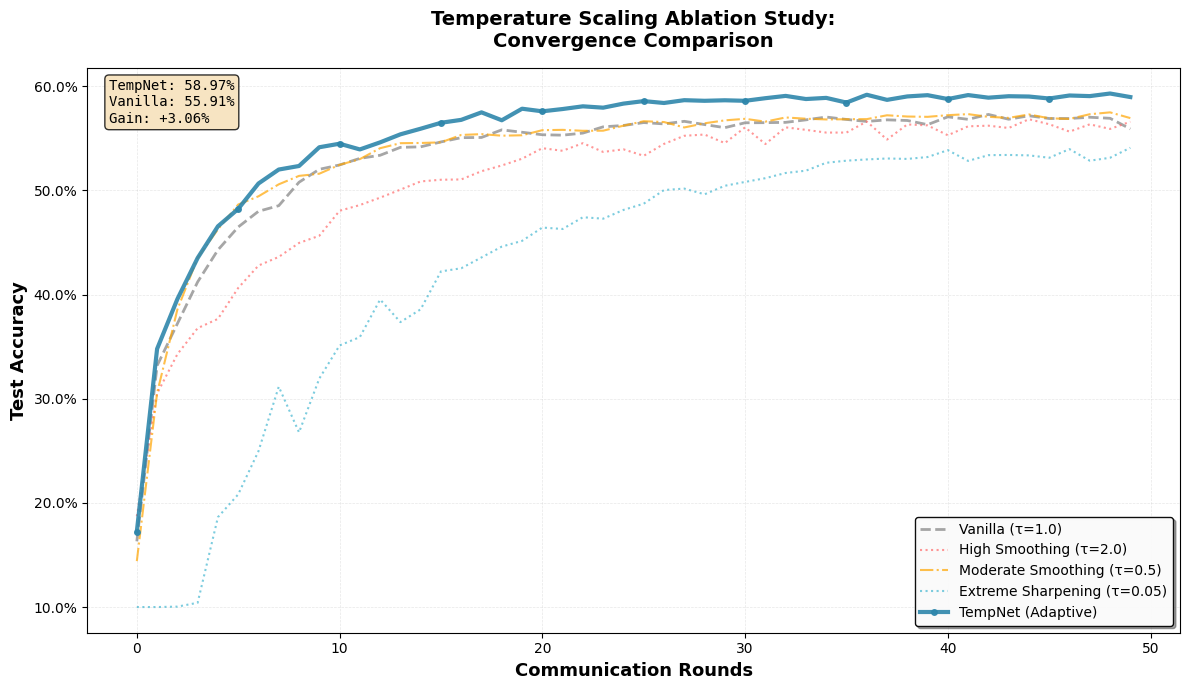


TEMPERATURE ABLATION SUMMARY TABLE

Method                         τ Value         Final Acc       Peak Acc        Avg Acc         Gain vs Vanilla     
----------------------------------------------------------------------------------------------------
TempNet (Adaptive)             Learned          58.97%✓        59.31%         55.21%        +3.06%
Moderate Smoothing (τ=0.5)     0.50             56.95%         57.50%         53.44%        +1.04%
High Smoothing (τ=2.0)         2.00             56.60%         56.84%         50.88%        +0.69%
Vanilla (τ=1.0)                1.00             55.91%         57.30%         53.15%        +0.00%
Extreme Sharpening (τ=0.05)    0.05             54.10%         54.10%         42.83%        -1.81%

[STATISTICAL ANALYSIS]

  Best Method:     TempNet (Adaptive)
  Best Accuracy:   58.97%
  ✓ TempNet OUTPERFORMS all fixed temperatures
  ✓ Adaptive learning provides +3.06% gain over vanilla

[CONVERGENCE SPEED]
  TempNet (Adaptive)             → 14 

In [23]:
# Step 3: Visualize results
visualize_temperature_comparison(
    all_results, 
    save_path='temperature_ablation_comparison.png'  # Optional: save figure
)

# Step 4: Access individual results
print(f"\nAdaptive TempNet final accuracy: {all_results['adaptive']['test_acc'][-1]:.4f}")
print(f"Vanilla (τ=1.0) final accuracy: {all_results['vanilla']['test_acc'][-1]:.4f}")
print(f"Improvement: {(all_results['adaptive']['test_acc'][-1] - all_results['vanilla']['test_acc'][-1])*100:+.2f}%")

---

In [24]:
ALPHA = 5


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    print("ALPHA = ", alpha)

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

ALPHA =  5
Data partitioning complete.
Client 0 class dist: ['0:0.02', '1:0.09', '2:0.09', '3:0.07', '4:0.13', '5:0.12', '6:0.07', '7:0.26', '8:0.01', '9:0.14']
Client 1 class dist: ['0:0.17', '1:0.06', '2:0.20', '3:0.09', '4:0.04', '5:0.08', '6:0.19', '7:0.06', '8:0.11', '9:0.00']
Client 2 class dist: ['0:0.03', '1:0.06', '2:0.13', '3:0.10', '4:0.11', '5:0.07', '6:0.14', '7:0.05', '8:0.13', '9:0.18']
Client 3 class dist: ['0:0.13', '1:0.08', '2:0.06', '3:0.11', '4:0.15', '5:0.04', '6:0.07', '7:0.05', '8:0.13', '9:0.17']
Client 4 class dist: ['0:0.12', '1:0.14', '2:0.07', '3:0.11', '4:0.12', '5:0.14', '6:0.09', '7:0.15', '8:0.07', '9:0.00']
Client 5 class dist: ['0:0.10', '1:0.15', '2:0.12', '3:0.10', '4:0.06', '5:0.12', '6:0.03', '7:0.10', '8:0.15', '9:0.07']
Client 6 class dist: ['0:0.07', '1:0.05', '2:0.06', '3:0.18', '4:0.11', '5:0.07', '6:0.18', '7:0.11', '8:0.18', '9:0.00']
Client 7 class dist: ['0:0.11', '1:0.21', '2:0.09', '3:0.07', '4:0.08', '5:0.09', '6:0.07', '7:0.13', '8:0.

In [25]:
# train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

all_results = run_temperature_ablation_suite(
    train_loaders, val_loaders, test_loader, device, 
    num_rounds=50  # Adjust as needed
)


COMPREHENSIVE TEMPERATURE ABLATION STUDY

EXPERIMENT: Vanilla (τ=1.0)
Fixed Temperature τ = 1.0
  Round 1/50: Test Acc = 0.3064 | Avg Local Val = 0.4049
  Round 11/50: Test Acc = 0.6029 | Avg Local Val = 0.5625
  Round 21/50: Test Acc = 0.6275 | Avg Local Val = 0.5846
  Round 31/50: Test Acc = 0.6353 | Avg Local Val = 0.5875
  Round 41/50: Test Acc = 0.6381 | Avg Local Val = 0.6000
  Round 50/50: Test Acc = 0.6421 | Avg Local Val = 0.6026
  Final Test Accuracy: 0.6421

EXPERIMENT: High Smoothing (τ=2.0)
Fixed Temperature τ = 2.0
  Round 1/50: Test Acc = 0.3018 | Avg Local Val = 0.3529
  Round 11/50: Test Acc = 0.5509 | Avg Local Val = 0.5240
  Round 21/50: Test Acc = 0.6172 | Avg Local Val = 0.5685
  Round 31/50: Test Acc = 0.6350 | Avg Local Val = 0.5891
  Round 41/50: Test Acc = 0.6369 | Avg Local Val = 0.5737
  Round 50/50: Test Acc = 0.6382 | Avg Local Val = 0.5872
  Final Test Accuracy: 0.6382

EXPERIMENT: Moderate Smoothing (τ=0.5)
Fixed Temperature τ = 0.5
  Round 1/50: Test Ac


GENERATING CONVERGENCE COMPARISON VISUALIZATION
  Figure saved to: temperature_ablation_comparison.png


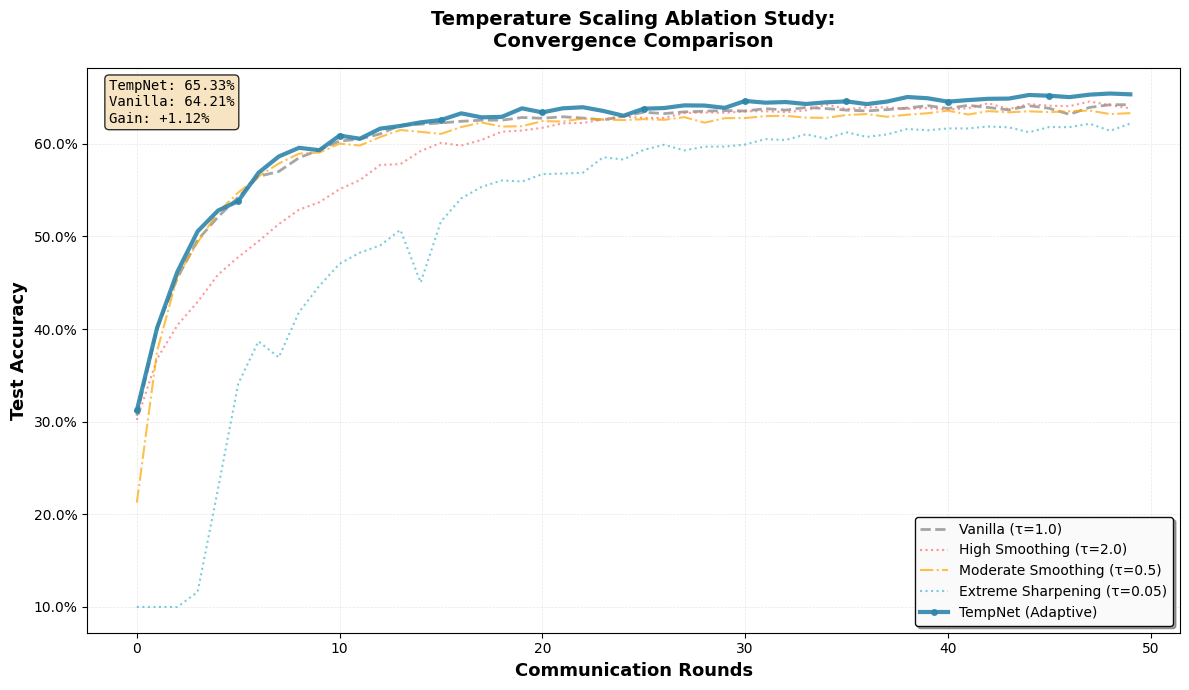


TEMPERATURE ABLATION SUMMARY TABLE

Method                         τ Value         Final Acc       Peak Acc        Avg Acc         Gain vs Vanilla     
----------------------------------------------------------------------------------------------------
TempNet (Adaptive)             Learned          65.33%✓        65.42%         61.31%        +1.12%
Vanilla (τ=1.0)                1.00             64.21%         64.21%         60.59%        +0.00%
High Smoothing (τ=2.0)         2.00             63.82%         64.56%         58.91%        -0.39%
Moderate Smoothing (τ=0.5)     0.50             63.30%         63.58%         59.91%        -0.91%
Extreme Sharpening (τ=0.05)    0.05             62.18%         62.18%         51.69%        -2.03%

[STATISTICAL ANALYSIS]

  Best Method:     TempNet (Adaptive)
  Best Accuracy:   65.33%
  ✓ TempNet OUTPERFORMS all fixed temperatures
  ✓ Adaptive learning provides +1.12% gain over vanilla

[CONVERGENCE SPEED]
  TempNet (Adaptive)             → 30 

In [26]:
# Step 3: Visualize results
visualize_temperature_comparison(
    all_results, 
    save_path='temperature_ablation_comparison.png'  # Optional: save figure
)

# Step 4: Access individual results
print(f"\nAdaptive TempNet final accuracy: {all_results['adaptive']['test_acc'][-1]:.4f}")
print(f"Vanilla (τ=1.0) final accuracy: {all_results['vanilla']['test_acc'][-1]:.4f}")
print(f"Improvement: {(all_results['adaptive']['test_acc'][-1] - all_results['vanilla']['test_acc'][-1])*100:+.2f}%")